In [25]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pathlib 
import os

import torch
from torch import nn
from torch.utils.data import DataLoader

import PT_files.save_load as sl

In [2]:
def np_BatchNorm2d(x, weights_dict, epsilon=1e-5):
    """
    Computes the batch normalized version of the input.
    
    This function implements a BatchNorm2d from PyTorch. A caveat to
    remember is that this implementation is equivalent to nn.BatchNorm2d
    in `model.eval()` mode. Batch normalization renormalizes the input 
    to the layer to a more parsable data range.
    
    Parameters:
    -----------
    x: numpy.ndarray
        Input image data.
    mean: numpy.ndarray
        Running mean of the dataset, computed during training.
    var: numpy.ndarray
        Running variance of the dataset, computed during training.
    beta: numpy.ndarray
        Offset value added to the normalized output.
        (These are the biases from the model parameter dictionary).
    gamma: numpy.ndarray
        Scale value to rescale the normalzied output.
        (These are the weights from the model parameter dictionary).
    epsilon: float
        Small constant for numerical stability. 
        Default = 1e-5.
        
    Returns:
    --------
    numpy.ndarray
        Output of the batch normalization.
        
    Notes:
    ------
    The operation implemented in this function is:
    
    .. math:: \\frac{\gamma (x - \mu)}{\sigma + \epsilon} + \\beta
    
    where :math:`\mu` is the running mean of the dataset and :math:`\sigma` is
    the running variance of the dataset, both of which are computed during
    training.
    
    For more details and documentation on the PyTorch BatchNorm2d function
    that this function mimics can be found at 
    https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html
    """
    gamma = weights_dict['weight'].detach().numpy()
    beta = weights_dict['bias'].detach().numpy()
    mean = weights_dict['running_mean'].detach().numpy()
    var = weights_dict['running_var'].detach().numpy()
    
    output = ((x - mean) / np.sqrt(var + epsilon)) * gamma + beta
    return output

In [3]:
#Load the actual data that we're working on & print the shape of this data
test_data = sl.NERSC_load('test_data_40%_6000.npy')
sample = test_data[0]
print('Shape of test set=', sample.shape)

# Create a minibatch of size 3 and cut the samples into 200x200 patch_sizes
# as well as converting it to pytorch for it to be used in the pytorch model
sample = sample[0:3, :, 1400:1600, 1400:1600]
sample_torch = torch.from_numpy(sample)

# Create batchnorm layer of DnCNN from pytorch 
# & get the pytorch dictionary that is created to be used in the numpy version of BatchNorm2d
# & get the output of this layer
model = nn.BatchNorm2d(num_features=1)#, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) # 1 output channels (everything after num features is default)
params = model.state_dict()
model.eval()
with torch.no_grad():
    pytorch_output = model(sample_torch)
# print the output shape
print('PyTorch shape output =', pytorch_output.shape)
# Lastly let's visualize the first samples first feature map
# plt.imshow(output[0][0].detach().numpy(), origin='lower')

# Numpy version using the pytorchs weights 
numpy_output = np_BatchNorm2d(x=sample,
                         weights_dict=params)
print('Numpy output =',numpy_output.shape)

Shape of test set= (108, 1, 6000, 6000)
PyTorch shape output = torch.Size([3, 1, 200, 200])
Numpy output = (3, 1, 200, 200)


In [4]:
np.isclose(numpy_output, pytorch_output.detach().numpy())

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True

In [8]:
def pytorch_numpy_comparison(input_data,
                             pytorch_output,
                             numpy_output,
                             sample_idx):
    
    
    
    fig, ax = plt.subplots(1, 3, figsize=(24,20))
    vmin, vmax = np.percentile(input_data[sample_idx], (1,99))
    # vmin, vmax = np.percentile(pytorch_output[sample][feature_map], (1,99))


    ax[0].imshow(pytorch_output[sample_idx][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[0].axis('off')
    ax[0].set_title('Pytorch BatchNorm', fontsize=30)
    ax[1].imshow(input_data[sample_idx][0],vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[1].axis('off')
    ax[1].set_title('Input Sample', fontsize=30)
    ax[2].imshow(numpy_output[sample_idx][0], vmin=vmin, vmax=vmax, origin='lower', interpolation='none')
    ax[2].axis('off')
    ax[2].set_title('Numpy BatchNorm', fontsize=30)

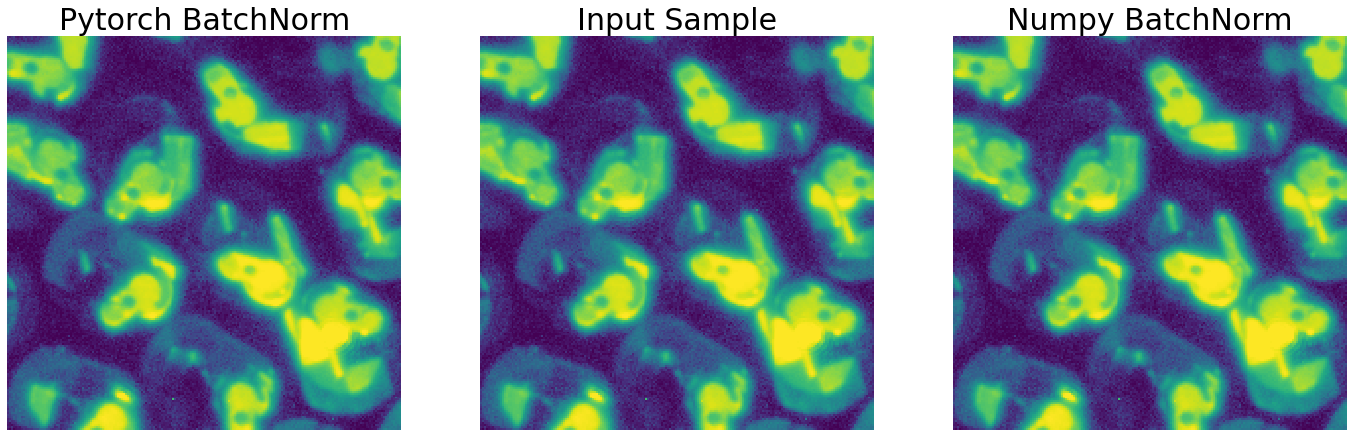

In [10]:
pytorch_numpy_comparison(input_data=sample,
                             pytorch_output=pytorch_output,
                             numpy_output=numpy_output,
                             sample_idx=2)

In [15]:
np.isclose(pytorch_output, sample)

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True

In [16]:
np.isclose(numpy_output, sample)

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True

In [17]:
np.isclose(pytorch_output, numpy_output)

array([[[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True]]],


       [[[ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True,  True, ...,  True,  True,  True],
         ...,
         [ True,  True,  True, ...,  True,  True,  True],
         [ True,  True